rtl_sdr_fm_audio_2023

This captures an FM radio signal of a specified duration, demodulates it in a very simple fashion, and plays the audio over the computer's speaker.

In [1]:
4+2 # Test if kernel is running

6

In [2]:
import time
import numpy as  np
import matplotlib.pyplot as plt
import sounddevice as sd
from copy import copy
np.set_printoptions(precision=2)

In [6]:
# Close old SDR instance
# Need to do this before you can adjust sampling frequency
# Drivers must be installed for this to work
# If this gives an error (eg because another program is controlling
# the SDR), close the other program and restart this kernel
from rtlsdr import RtlSdr 
# Close previous instances of the sdr object
try: 
    sdr.close()
    print("Closed old SDR")
except NameError:
   print("No SDR instance found")

Closed old SDR


In [7]:
sdr = RtlSdr() # Create a new sdr object (by keeping this in 
               # the block above can be used to close sdr without
               # creating a new sdr instance, which you might want to
               # do when switching to a new program
               # If this fails (eg with "usb_claim_interface error -3" on Mac), try 
               # (1) Unpluging and re-inserting the RTL SDR device
               # (2) running close block above
               # (3) closing other programs that may be using SDR
               # (4) restarting this kernel
               # If you see "PLL not locked!" that is normal behavior...not a problem.

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [5]:
# Don't run this cell unless you are about to quit.
sdr.close()

In [8]:
# Making samples per sec a multiple of 256 means that if
# we sample for simple multiples of 1 s, our number of samples
# will be multiples of 256, which is a requirement
# fsps = 3*256*256*16 # = 3145728 about 3Msps...SEEMS to work (but see below)...3.5Msps and above gives error
# Note that while 3Msps does seem to work, the time it takes to collect the samples
# ends up being a lot longer than it should...maybe it's doing some kind of
# oversampling to get the values for high sampling rates?
#fsps = 256*256*16 # = 1048576 ... about 1Msps...works
fsps = 2*256*256*16 # =  ... about 2Msps...works
faudiosps =48000 # audio sampling frequency (for output)

fc = 94.9e6 # KUOW Seattle
#fc = 89.7e6 # KWWS Walla Walla
#fc = 90.3e6 # Some Seattle station
#fc = 89.7e6 # adjacent to 89.7 for validation
#fc = 89.8e6 # adjacent to 89.7 for validation

#fc = 92.6e6 # adjacent to spanish language station at 92.5

# For SMArt XTR...small gap at 1100MHz
#fcmin = 55e6
#fcmax = 2300e6

#fcmin = 88e6 # lowest freq in US FM band
#fcmax = 108e6 # highest freq in US FM band

# specify sampling frequency
dt = 1.0/fsps # time step size between samples
nyquist = fsps /2.0


#Tmax = 10.0       # 5 s
#Tmax = 5.0       # 5 s
Tmax = 2.5        # 2.5 s
#Tmax = 1.0        # 1 s
#Tmax = 0.125     # 1/8  s = 125ms
#Tmax = 0.0625    # 1/16 s = 62 ms 
#Tmax = 0.03125   # 1/32 s = 31 ms
#Tmax = 0.015625  # 1/64 s = 16 ms
#Tmax = 0.0078125 # 1/128s = 7.8ms
#Tmax = 0.00390625 # 1/256s = 3.9ms

N = round(fsps*Tmax) # N must be a multiple of 256
print("The number of samples to collect, N= ",N)

sdr.sample_rate = fsps 
sdr.center_freq = fc

print("The valid gains are")
print(sdr.valid_gains_db)
#sdr.gain = 'auto'
sdr.gain = 42.0 # This is max on rtl_sdr v4, according to sdr.valid_gains_db
print("We are using ")
print("Gain (0==auto)  : ", sdr.gain)
print("Sample Rate     : ", sdr.sample_rate)
print("Center frequency: ", sdr.center_freq)

The number of samples to collect, N=  5242880
The valid gains are
[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]
We are using 
Gain (0==auto)  :  42.1
Sample Rate     :  2097152.0
Center frequency:  94900000


In [12]:
#***
# Collect samples
samples = ((np.zeros((N))+1j)-1j) # Trick it into being an array of complex zeros
print("Sampling with center frequency ", fc, " for ", Tmax, " seconds")
sdr.center_freq = fc
print("Frequency spans from ", (fc-nyquist)/1e6," to ", (fc+nyquist)/1e6,"MHz")

print("SDR gain:", sdr.gain)

#RF_record_start_time = time.time()
samples = sdr.read_samples(N) # Collect N samples...N must be multiple of 256end_time = time.time()
#RF_record_end_time = time.time()
#RF_record_duration_actual = RF_record_end_time - RF_record_start_time
#print("Actual time duration of RF recording: ",RF_record_duration_actual)
#print("Commanded samples per second=", fsps)
#print("Actual samples per second= ", N/RF_record_duration_actual)
#print("Percentage deviation= ", (-100*(fsps-(N/RF_record_duration_actual))/fsps))

Sampling with center frequency  94900000.0  for  2.5  seconds
Frequency spans from  93.851424  to  95.948576 MHz
SDR gain: 42.1


In [11]:
# Save the arrays to a file
np.savez('savefile-2023-04-27-11-18', samples=samples)

In [ ]:
# Load the arrays from the file
data = np.load('savefile-2023-04-27-11-18.npz')
samples = data['samples']
N = len(samples)

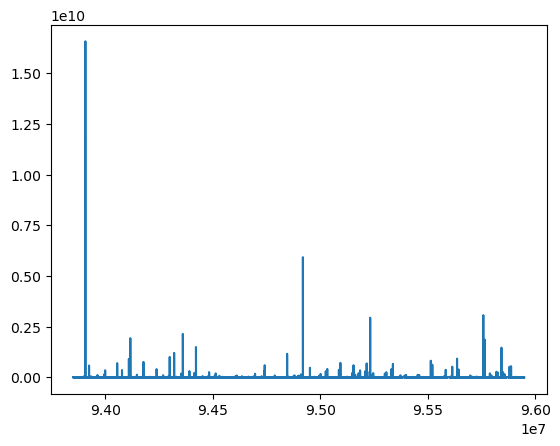

In [13]:
#***
# Compute and plot the spectrum for the samples just collected
freqs = np.zeros((N))
spectrum = ((np.zeros((N))+1j)-1j)
#maxval = 0.0
#maxind = 0.0

#plt.figure(figsize=(16,12))
plt.figure()
spectrum = np.fft.fftshift(np.fft.fft(samples))
#maxval = np.amax(np.abs(spectrum))
#maxindi = np.argmax(np.abs(spectrum))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
plt.plot(freqs,np.abs(spectrum*spectrum.conjugate()));
#plt.plot(freqs/1e6,10*np.log10(np.real(spectrum*spectrum.conjugate())/noisepowerperbinfd))
#plt.title("Signal-to-Noise ratio, in dB")
#print("For band from ", (fc-nyquist)/1e6, " to ",(fc+nyquist)/1e6, "MHz,")
#print(" max is", round(10*np.log10((maxval**2)/noisepowerperbinfd)), "dB, at ", freqs[maxindi]/1e6, "MHz (index ", round(maxindi),")")
#print(" max is", maxval**2, " at ", freqs[maxindi]/1e6, "MHz (index ", round(maxindi),")")

In [14]:
# stopband width, passband width, passband full width (double sided)
#
#      sbw        pbfw       sbw
#   --------+++++++++++++--------
#           -fc          fc
#  -nyq            0             +nyq
# returns a length N vector consisting  
# ones in the middle, padded by zeros on the left and right
# fcutoff is the one-sided cutoff frequency
# so if fcutoff is 100kHz, the pass band will extend from 
# bin N/2 - 100kHz to bin N/2 + 100kHz
def bandpassmask(N,fsps,fcutoff):
    fcutoff_n = fcutoff / fsps # fcutoff, normalized

    pbfw = round(2*fcutoff_n*N)
    sbw = int((N-pbfw)/2)
    print("N= ", N, " fsps= ",fsps, " fcutoff=", fcutoff, " fcutoff_n= ",fcutoff_n," pbfw= ", pbfw, " sbw= ", sbw)
    res = np.concatenate((np.zeros(sbw),np.ones(pbfw),np.zeros(sbw)))
    print("total= ",pbfw+sbw+sbw)
    return(res)

N=  5242880  fsps=  2097152  fcutoff= 100000  fcutoff_n=  0.0476837158203125  pbfw=  500000  sbw=  2371440
total=  5242880


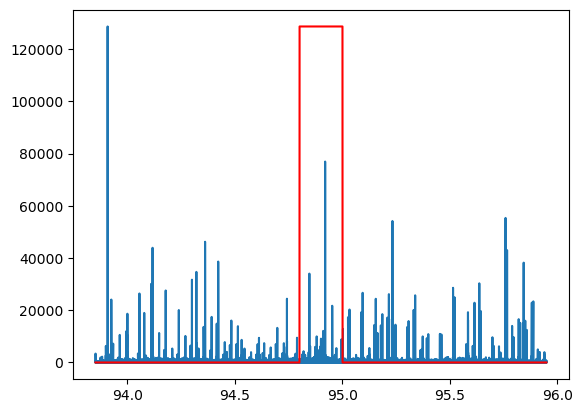

In [15]:
# Create and plot the bandpass mask
fcutoff = 100000 # Cutoff frequency of filter 100kHz
bpm = bandpassmask(N,fsps,fcutoff) # create the bandpass mask
plt.figure()
height = np.max(np.abs(spectrum))
plt.plot(freqs/1e6,np.abs(spectrum))
plt.plot(freqs/1e6,height*bpm,'r');

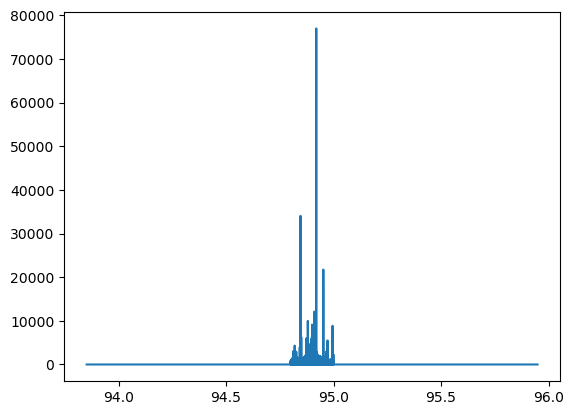

In [16]:
#***
# Filter by applying frequency mask to spectrum
filteredspectrum = spectrum * bpm
plt.plot(freqs/1e6,np.abs(filteredspectrum));

In [17]:
#***
# Convert masked spectrum back to time domain to get filtered signal 
filteredsignal = np.fft.ifft(np.fft.fftshift(filteredspectrum)) # Good results

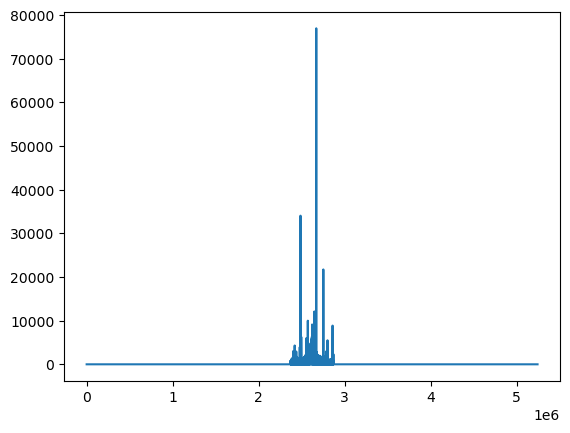

In [18]:
# For validation, also convert from time back to freq to make sure 
# we didn't mess something up (ie to make sure we get back spectrum)
# we started with
validatefilteredsignal = np.fft.fftshift(np.fft.fft(filteredsignal))
plt.figure()
plt.plot(np.abs(validatefilteredsignal));

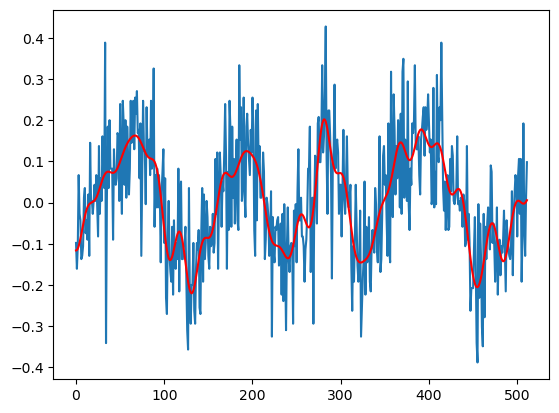

In [19]:
# Compare time domain view of filtered and un-filtered signal
plt.figure()
plt.plot(np.real(samples[0:512]))
plt.plot(np.real(filteredsignal[0:512]),'r');

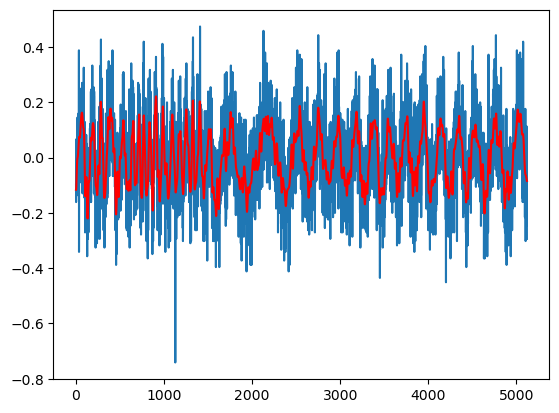

In [20]:
# Same as above, but longer time window
plt.figure()
plt.plot(np.real(samples[0:5120]))
plt.plot(np.real(filteredsignal[0:5120]),'r');

# Find $\frac{d\theta}{dt},$ the derivative of the phase $\theta$

First find the phase $\theta$ from the complex signals

In [21]:
#***
#theta = np.angle(filteredsignal)
theta = np.arctan2(filteredsignal.imag,filteredsignal.real)

# Squelch

In [22]:
abssignal = np.abs(filteredsignal)
meanabssignal = np.mean(abssignal)
thetasquelched = copy(theta)
filteredsquelched = copy(filteredsignal)
squelchthresh = (meanabssignal/3.0)
for i in range(N):
    if (abssignal[i]<squelchthresh):
        filteredsquelched[i] = 0.0
        thetasquelched[i] = 0.0

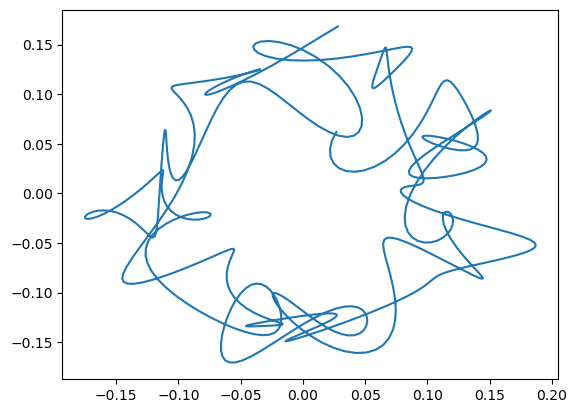

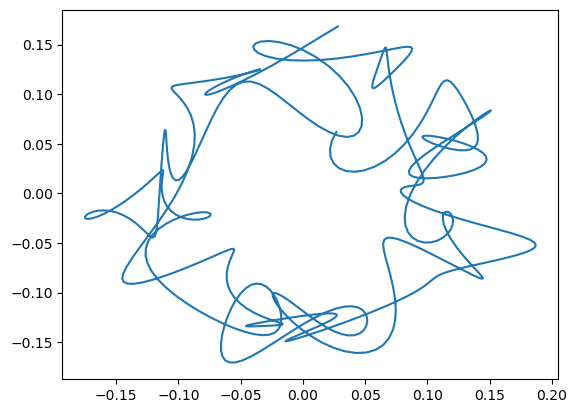

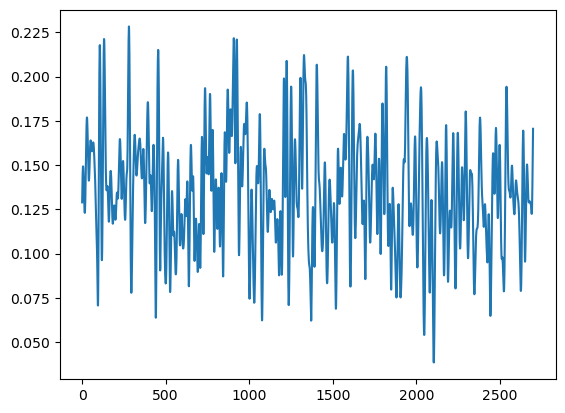

In [23]:
mins = int(2.1e3)
maxs = int(2.7e3)
alphaval = 1.0
#alphaval = 0.005
plt.figure()
#plt.plot(filteredsignal[mins:maxs].real,filteredsignal[mins:maxs].imag,'.',alpha=alphaval) # point
plt.plot(filteredsignal[mins:maxs].real,filteredsignal[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
#plt.plot(filteredsquelched[mins:maxs].real,filteredsquelched[mins:maxs].imag,'.',alpha=alphaval) # point
plt.plot(filteredsquelched[mins:maxs].real,filteredsquelched[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
plt.plot(np.abs(filteredsignal[0:maxs]));

# Find $\frac{d\theta}{dt}$
Note: np.convolve([1,-1]) computes the derivative 

In [ ]:
derivthetap0[100:110]-derivthetapp[100:110]

# Eliminate phase wrap errors

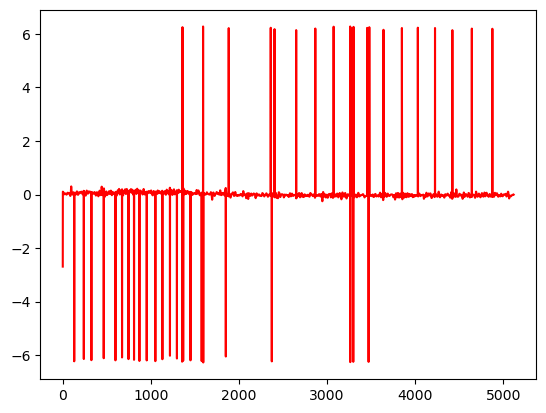

In [24]:
# deriv (theta plus 0)
derivthetap0 = np.convolve([1,-1],thetasquelched,'same')
derivthetapp = np.convolve([1,-1],(thetasquelched+np.pi) % (2*np.pi),'same')
plt.figure()
plt.plot(derivthetap0[0:5120],'r');

In [25]:
# The 0, +pi comparison method
# deriv (theta plus pi)
derivtheta = np.zeros(len(derivthetap0))
for i in range(len(derivthetap0)):
    if (abs(derivthetap0[i])<abs(derivthetapp[i])):
        derivtheta[i] = derivthetap0[i] 
    else:
        derivtheta[i] = derivthetapp[i] 
cdtheta = copy(derivtheta)

In [26]:
spikethresh = 2
# First let's look in detail at the first few spikes
for i in range(1000):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])

130    -6.234612388243583
239    -6.149102923120578
325    -6.191982887863961
465    -6.1200349806813055
598    -6.1985687719313685
673    -6.090449648629692
746    -6.152908169170304
809    -6.179157703024589
870    -6.222267046539196
953    -6.201096381632292


In [27]:
# and the last spikes
for i in range(len(derivtheta)-1000,len(derivtheta)):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])

5241894    2.956839605825121
5241910    -5.996327885777136
5241974    2.9653757392460047
5242016    -6.135845188692752
5242088    -2.991518696515537
5242093    6.229753306979305
5242114    2.651819489804422
5242118    -6.173558392984804
5242210    2.177756314745176
5242237    2.9454881235821766
5242239    -6.131925346409803
5242251    6.1220391260417975
5242269    -6.1942588289258715
5242275    2.901719297501709
5242296    2.9979532584995177
5242302    -2.5960292243158936
5242312    -2.3244870827940134
5242321    6.167571896846135
5242352    -6.16533921622667
5242393    6.151216753325526
5242402    -2.169067431354085
5242427    -5.982565723444726
5242442    6.13942919330397
5242453    -2.80242047565696
5242456    -2.87139471897373
5242463    6.147488032880862
5242470    -2.4490897750241594
5242476    -2.288894251561458
5242493    5.985581859915159
5242649    -2.0842728789348945
5242658    6.199298799767149
5242669    -6.198614899309897
5242675    2.7330819108085405
5242678    2.7627848

Pick threshold (spikethresh) large enough that the phase-wrap spikes are isolated...that will mean we can remove them nicely by averaging their neighbors. (Why wouldn't they be? Maybe noise could cause some weird things to happen, like bouncing back and forth across the $0-2 \pi$ phase wrap boundary a few times in a row? 

In [28]:
#***
#cdtheta = copy(derivthetap0) # Cleaned derivative of theta
cdtheta = copy(derivtheta) # Cleaned derivative of theta
for i in range(1,len(derivtheta)-1):
    if (abs(derivtheta[i])>spikethresh):
        cdtheta[i] = (derivtheta[i-1]+derivtheta[i+1])/2.0

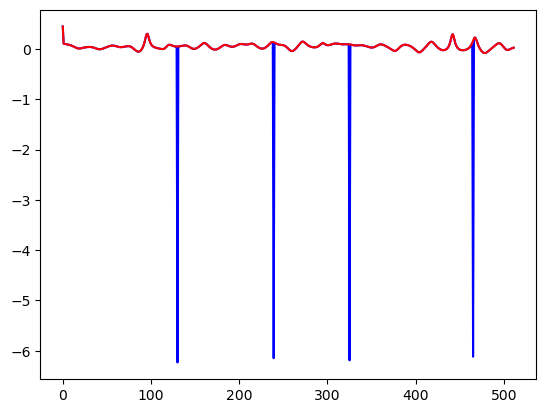

In [29]:
plt.figure()
plt.plot(derivtheta[0:512],'b');
plt.plot(cdtheta[0:512],'r');

Note: The y-scale on figure above ("cleaned") is -.2 to +.2...original un-cleaned y-scale was -2pi to +2pi...throwing away the wrap artifacts made a huge impact on our signal (at least when viewed using a plot with a y scale that is auto-selected to the max values). The next plots show the difference between the cleaned and un-cleaned signals once these outliers have been removed.

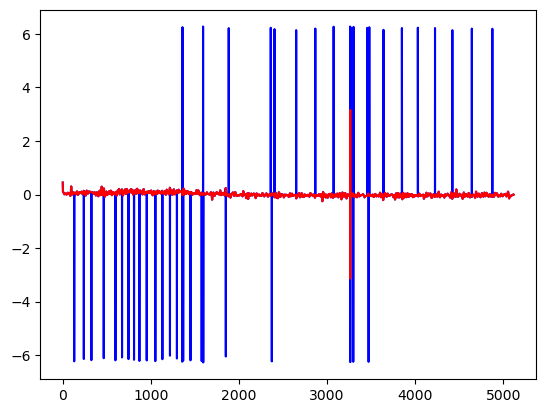

In [30]:
plt.figure()
plt.plot(derivtheta[0:5120],'b')
plt.plot(cdtheta[0:5120],'r')

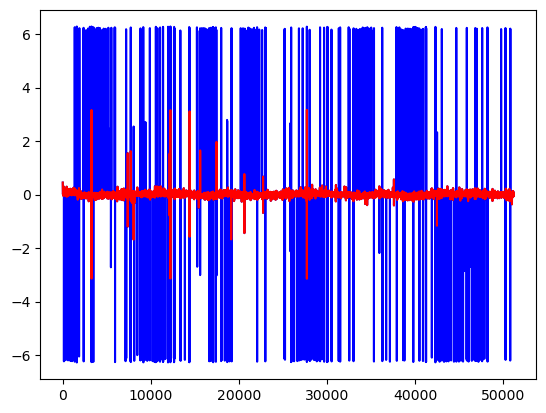

In [31]:
plt.figure()
plt.plot(derivtheta[0:51200],'b')
plt.plot(cdtheta[0:51200],'r');

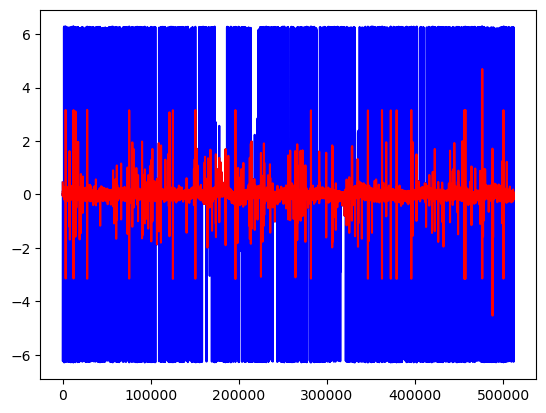

In [32]:
plt.figure()
plt.plot(derivtheta[0:512000],'b')
plt.plot(cdtheta[0:512000],'r');

The plot above shows that the cleaning had a huge effect!

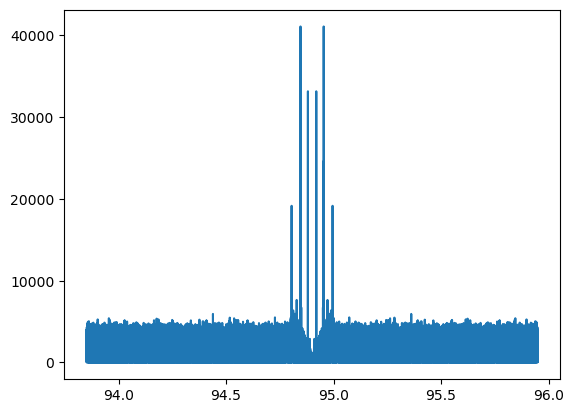

In [33]:
# In the frequency domain, getting rid of the wrap around errors is
# even more obvious
# With wrap around errors
FTderivtheta=np.fft.fftshift(np.fft.fft(derivtheta))
plt.figure
plt.plot(freqs/1e6,np.abs(FTderivtheta));

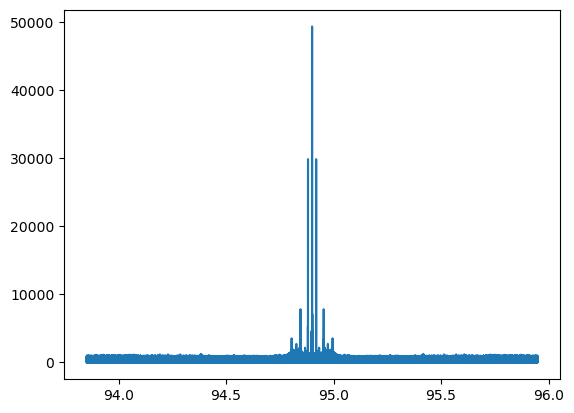

In [34]:
# Without wraparound errors
FTcdtheta=np.fft.fftshift(np.fft.fft(cdtheta))
plt.figure
plt.plot(freqs/1e6,np.abs(FTcdtheta));

In the frequency domain the cleaned & uncleaned signals look drastically different! Those spikes were really messing things up.

### Downsampling
Our RF samples are about 1Msps (one million samples per second)...our audio sub-system only plays about 48000 sps...so we need to downsample, ie throw away samples. First we'll look at Python notation for downsampling, and then we'll figure out how many samples we need to throw away

In [35]:
# How much do we need to downsample?
# Let's figure out the required downsampling factor
# For example, suppose we need to turn 1048576 sps into 48000 sps
# then the downsampling ratio = 1048576/48000, which is about 22
dsf = round(fsps/faudiosps) # round(1048576/48000)=22
print("Down sampling factor is", dsf)

Down sampling factor is 44


In [42]:
#*** DownSampled Cleaned Derivative of Theta
# Just keep every 44th sample
dscdtheta = cdtheta[::dsf] # downsample by 44th sample (or whatever dsf is)

In [46]:
#Better: Average in blocks of 44
dscdtheta2 = copy(dscdtheta)
for i in range(len(dscdtheta2)):
    dscdtheta2[i] = np.sum(cdtheta[i*dsf:(i+1)*dsf])/dsf
print("Length before downsampling: ",len(cdtheta))
print("Length after downsampling : ",len(dscdtheta2))
dscdtheta = copy(dscdtheta2)

Length before downsampling:  5242880
Length after downsampling :  119157


In [47]:
# Let's figure out the horizontal scale of the FT of the audio
faudionyquist = faudiosps/2.0
freqsaudio = np.linspace(-faudionyquist,+faudionyquist,len(dscdtheta))

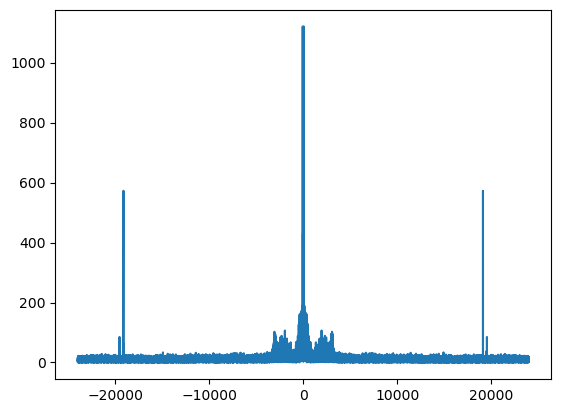

In [48]:
# FourierTransform of DownSampled Cleaned Derivative of Theta
FTdscdtheta=np.fft.fftshift(np.fft.fft(dscdtheta))
plt.figure
plt.plot(freqsaudio,np.abs(FTdscdtheta));

In [49]:
# Play Audio
#faudiosps defined at top (eg 48000)
dt_audio = 1/faudiosps
myaudio = dscdtheta
start_time = time.time()
sd.play(10*myaudio,faudiosps,blocking=True)